# Análisis predictivo de series temporales

-----

## Modelos de media móvil

In [1]:
#install.packages("devtools")     # only need to do this once
#devtools::install_github("nickpoison/astsa")
#install.packages("astsa")
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas


### Repaso: procesos autorregresivos

Recordemos primero la definición de proceso autorregresivo (de media 0):

> **Definición:** un proceso $\{x_t\}$ es autorregresivo de orden $p$ si admite la representación
>
> $$ x_t = \phi_1 x_{t-1} + \ldots + \phi_p x_{t-p} + w_t,$$
>
> con $w_t$ ruido blamco de varianza $\sigma_w^2$.

### Autocorrelación y autocorrelación parcial

En un proceso autorregresivo puro:

* La autocorrelación decae de forma exponencial como función del lag.
* La autocorrelación parcial se anula para lags mayores a $p$.

## Proceso de media móvil

> **Definición:** un proceso $\{x_t\}$ es una media móvil de orden $q$ o $MA(q)$ si verifica:
>
> $$ x_t = w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q},$$
>
> donde hay $q$ lags en la media móvil, $\theta_1,\ldots,\theta_q$ son parámetros, $\theta_q\neq0$ y $\{w_t\}$ es ruido blanco (Gaussiano) de varianza $\sigma^2_w$. 

* Es el proceso dual del AR, donde el valor actual depende de valores pasados del ruido solamente, y no de la propia serie. 
* El ruido blanco puede pensarse como una media móvil de orden $0$.
* Si $q>0$ el proceso es más suave que el ruido puro.

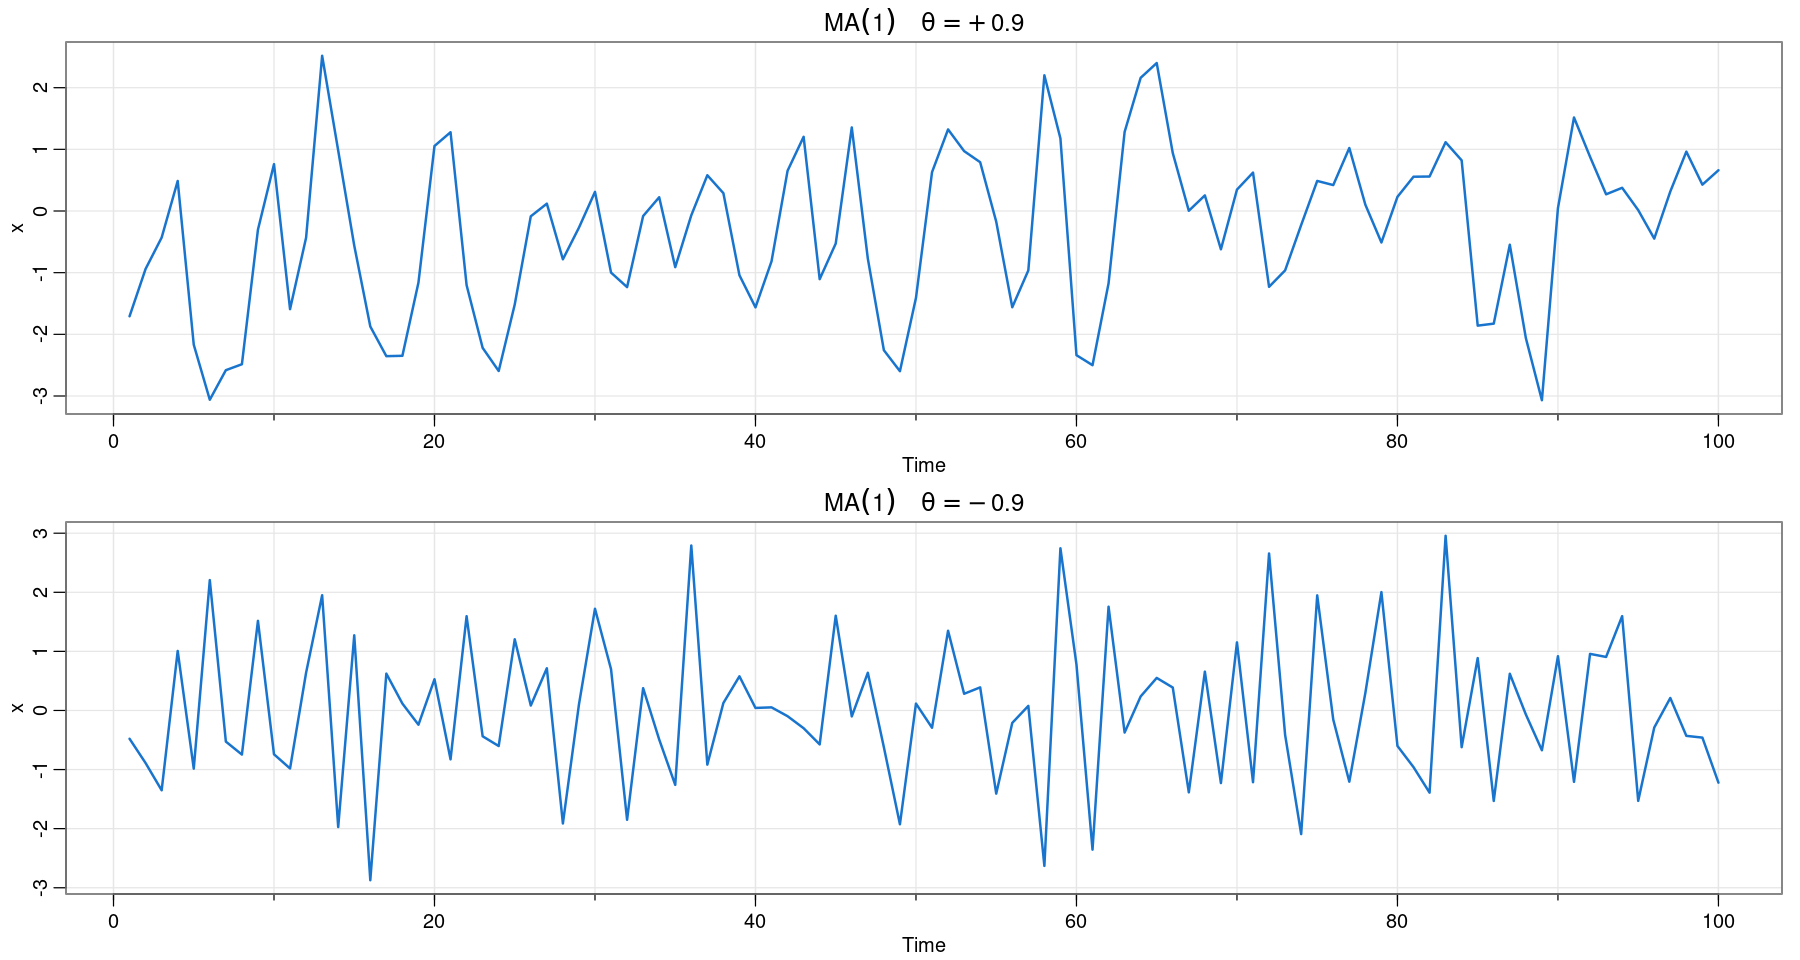

In [2]:
## Ejemplo: media movil de orden 1

par(mfrow=c(2,1))                                   
tsplot(arima.sim(list(order=c(0,0,1), ma=.9), n=100), ylab="x", col=4, lwd=2, main=(expression(MA(1)~~~theta==+.9)))    
tsplot(arima.sim(list(order=c(0,0,1), ma=-.9), n=100), ylab="x", col=4, lwd=2, main=(expression(MA(1)~~~theta==-.9)))  

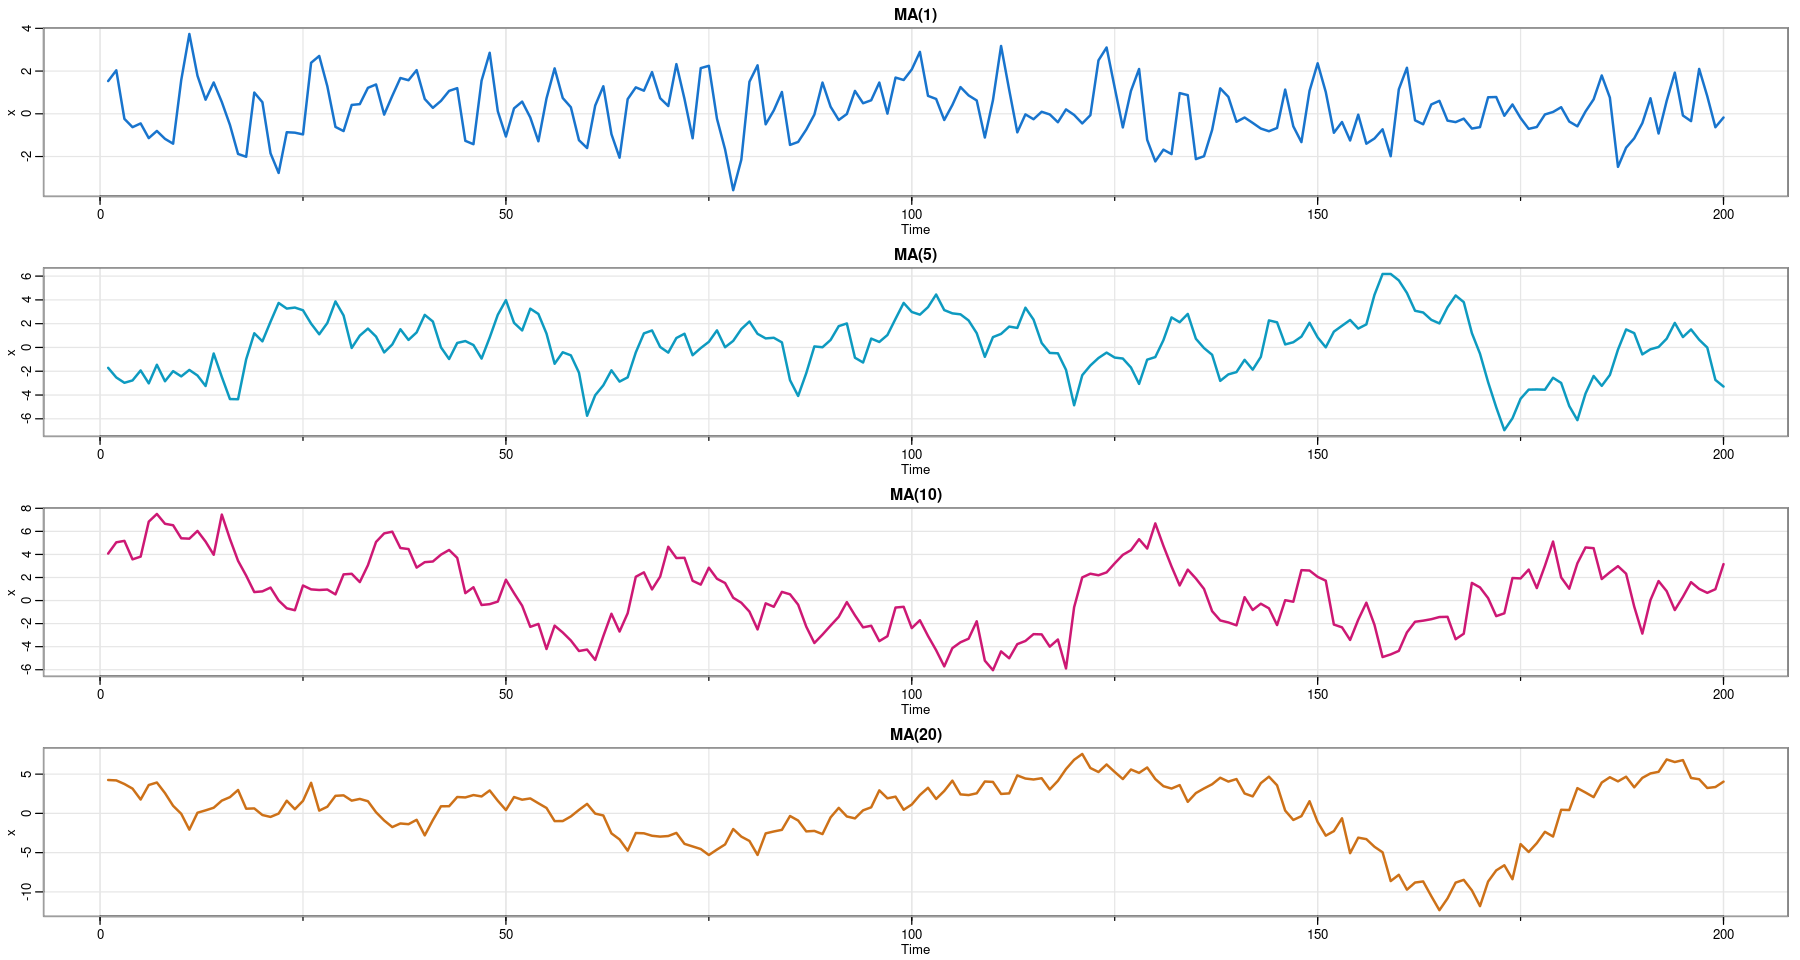

In [3]:
## Ejemplo: media movil de orden variable

par(mfrow=c(4,1))                                   
tsplot(arima.sim(list(order=c(0,0,1), ma=c(1)), n=200), col=4, lwd=2, ylab="x", main="MA(1)")
tsplot(arima.sim(list(order=c(0,0,5), ma=rep(1,5)), n=200), col=5, lwd=2, ylab="x", main="MA(5)")
tsplot(arima.sim(list(order=c(0,0,10), ma=rep(1,10)), n=200), col=6, lwd=2, ylab="x", main="MA(10)")
tsplot(arima.sim(list(order=c(0,0,20), ma=rep(1,20)), n=200), col=7, lwd=2, ylab="x", main="MA(20)")

### Ejemplo: media movil de orden 1

El proceso MA(1) está dado por

$$ x_t = w_t + \theta w_{t-1}.$$

**Propiedades**:

* $E[x_t] = E[w_t] + \theta E[w_{t-1}] = 0$.
* $E[x_t^2] = E[w_t^2] +  2\theta E[w_tw_{t-1}] + \theta^2 E[w_{t-1}^2] = (1+\theta^2)\sigma^2_w.$
* $E[x_t x_{t-1}] = E[(w_t + \theta w_{t-1})(w_{t-1} + \theta w_{t-2})] = \theta \sigma^2_w.$
* $E[x_t x_{t-h}] = 0$ si $h>1$ porque los ruidos que participan no están correlacionados.

Resumiendo, la función de autocovarianza de un MA(1) tiene la forma:

$$\gamma(h) = \left\{\begin{array}{ll}(1+\theta^2)\sigma_w^2 & h=0\\ \theta\sigma_w^2 & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

La función de autocorrelación es entonces:

$$\rho(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$


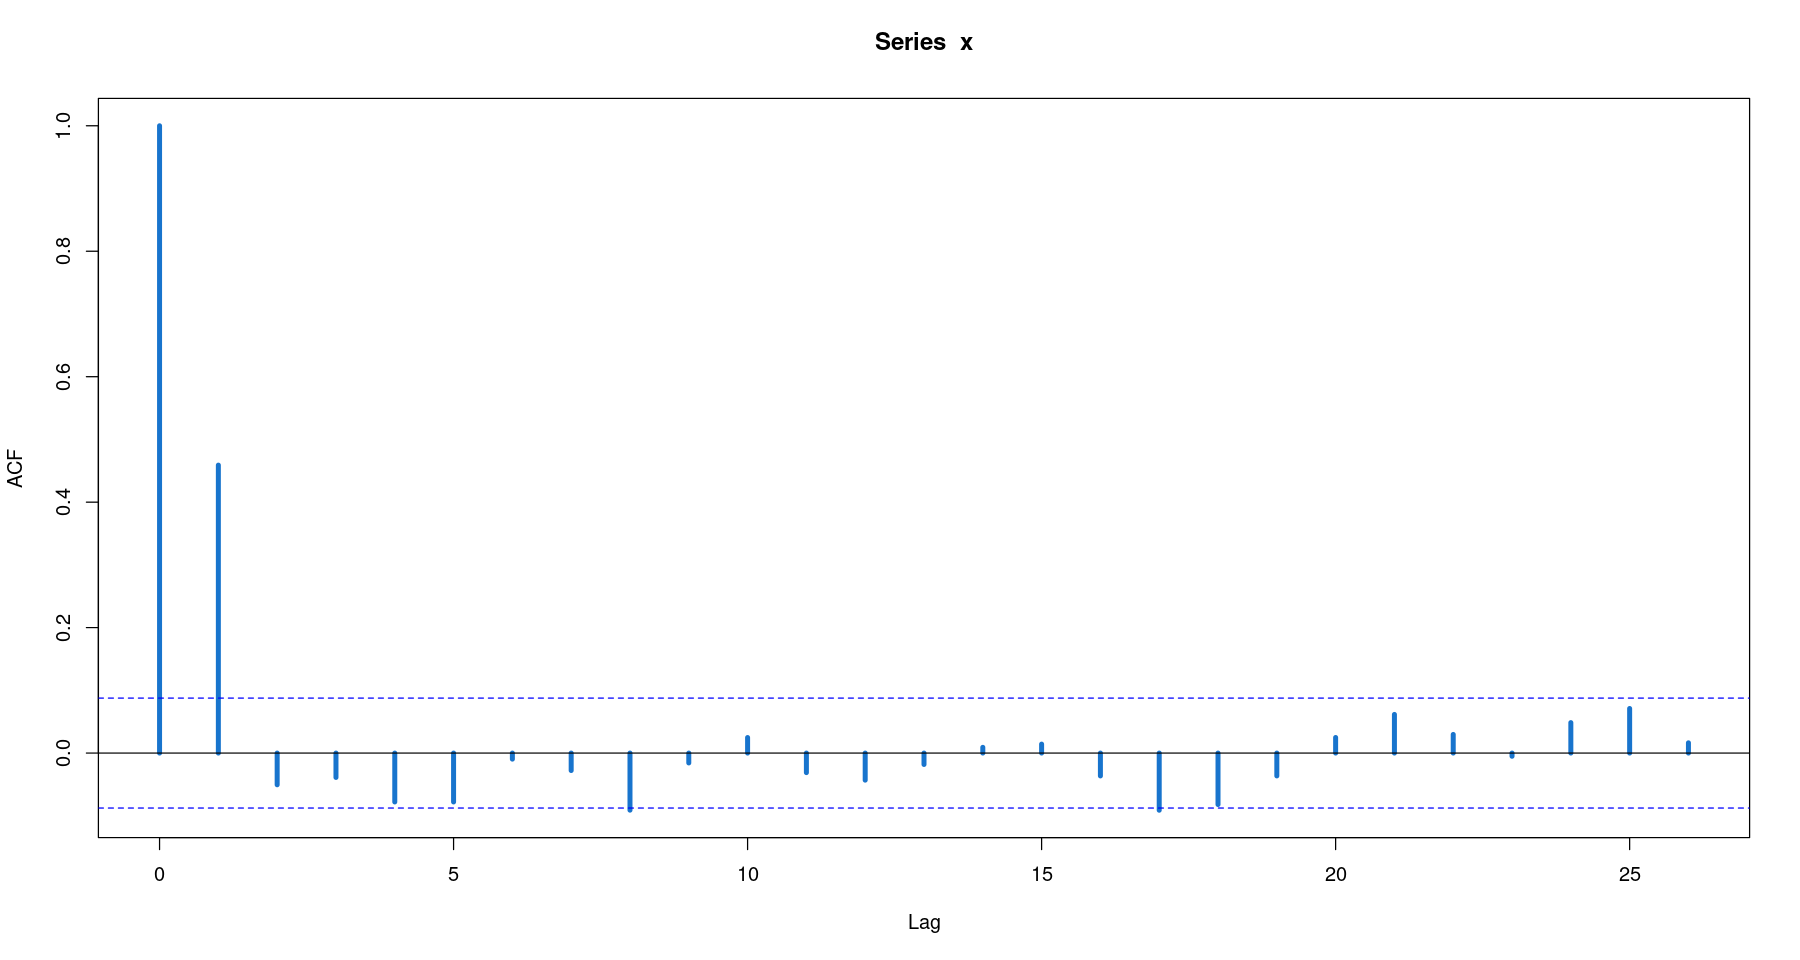

In [4]:
x=arima.sim(list(order=c(0,0,1), ma=c(1)), n=500)

acf(x, col=4, lwd=4)


La propiedad anterior es general, es decir, si $x_t$ es un proceso $MA(q)$ entonces la ACF de $x_t$ es $0$ para lags $h>q$.

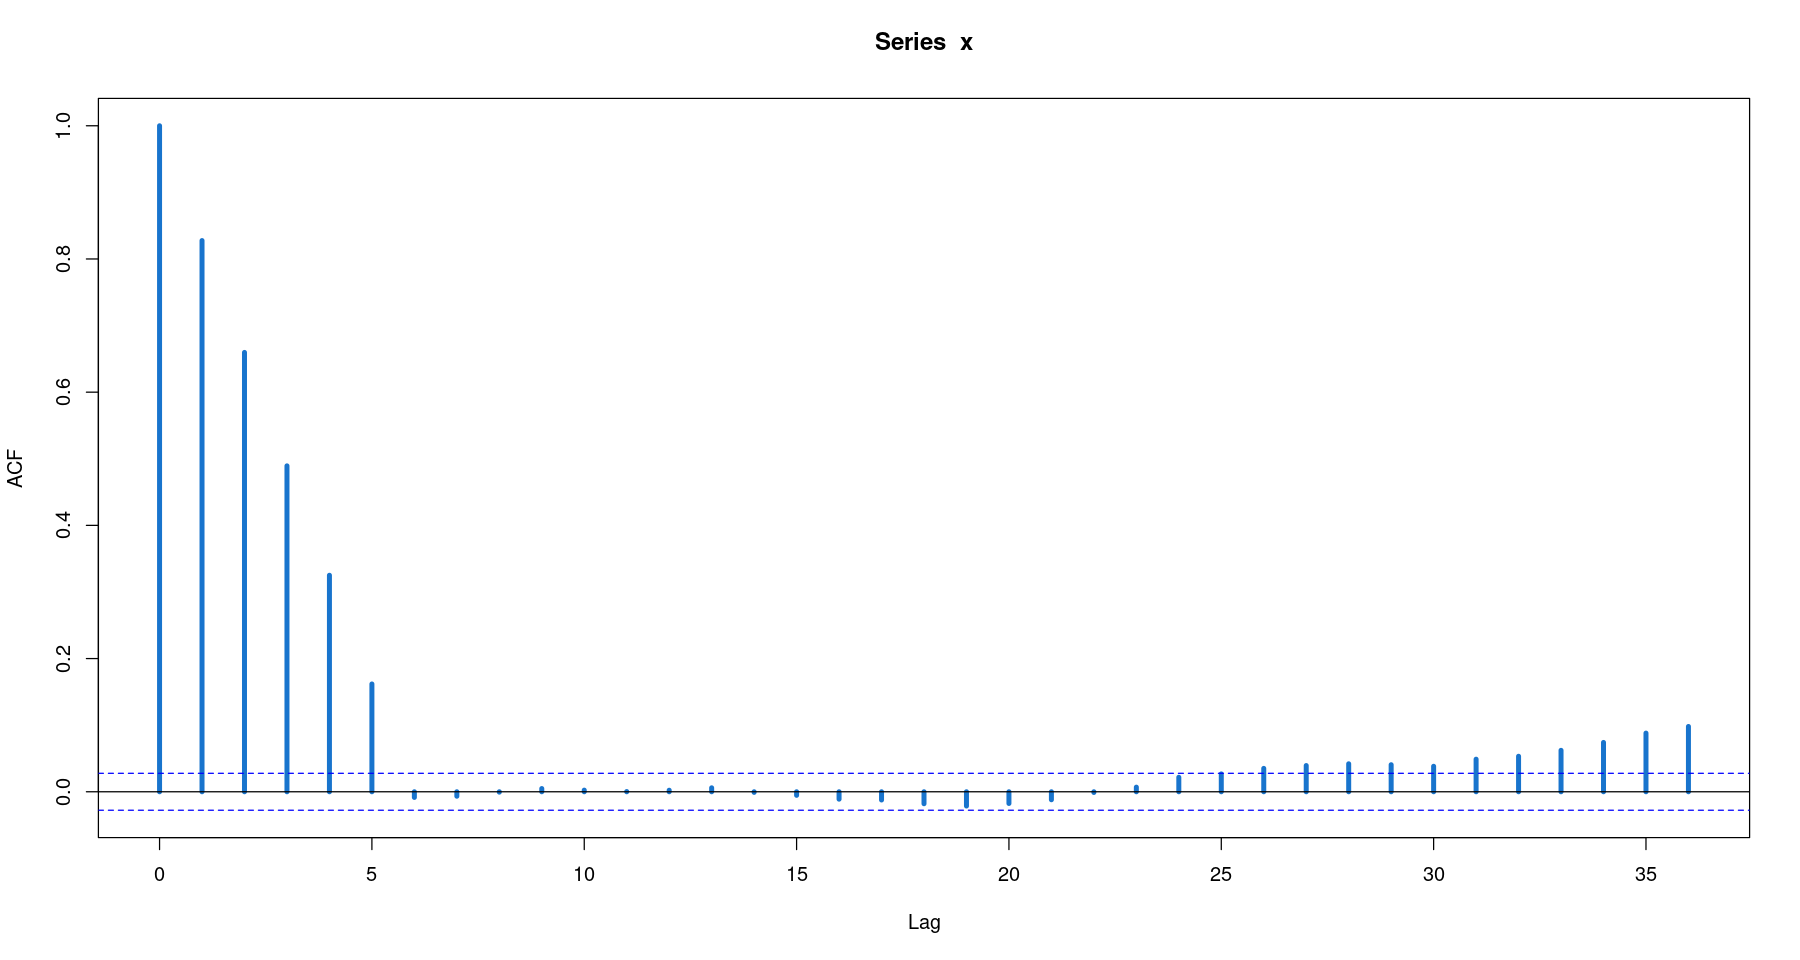

In [5]:
x=arima.sim(list(order=c(0,0,5), ma=c(1,1,1,1,1)), n=5000)

acf(x, col=4, lwd=4)

En cambio, la PACF no tiene el mismo comportamiento:

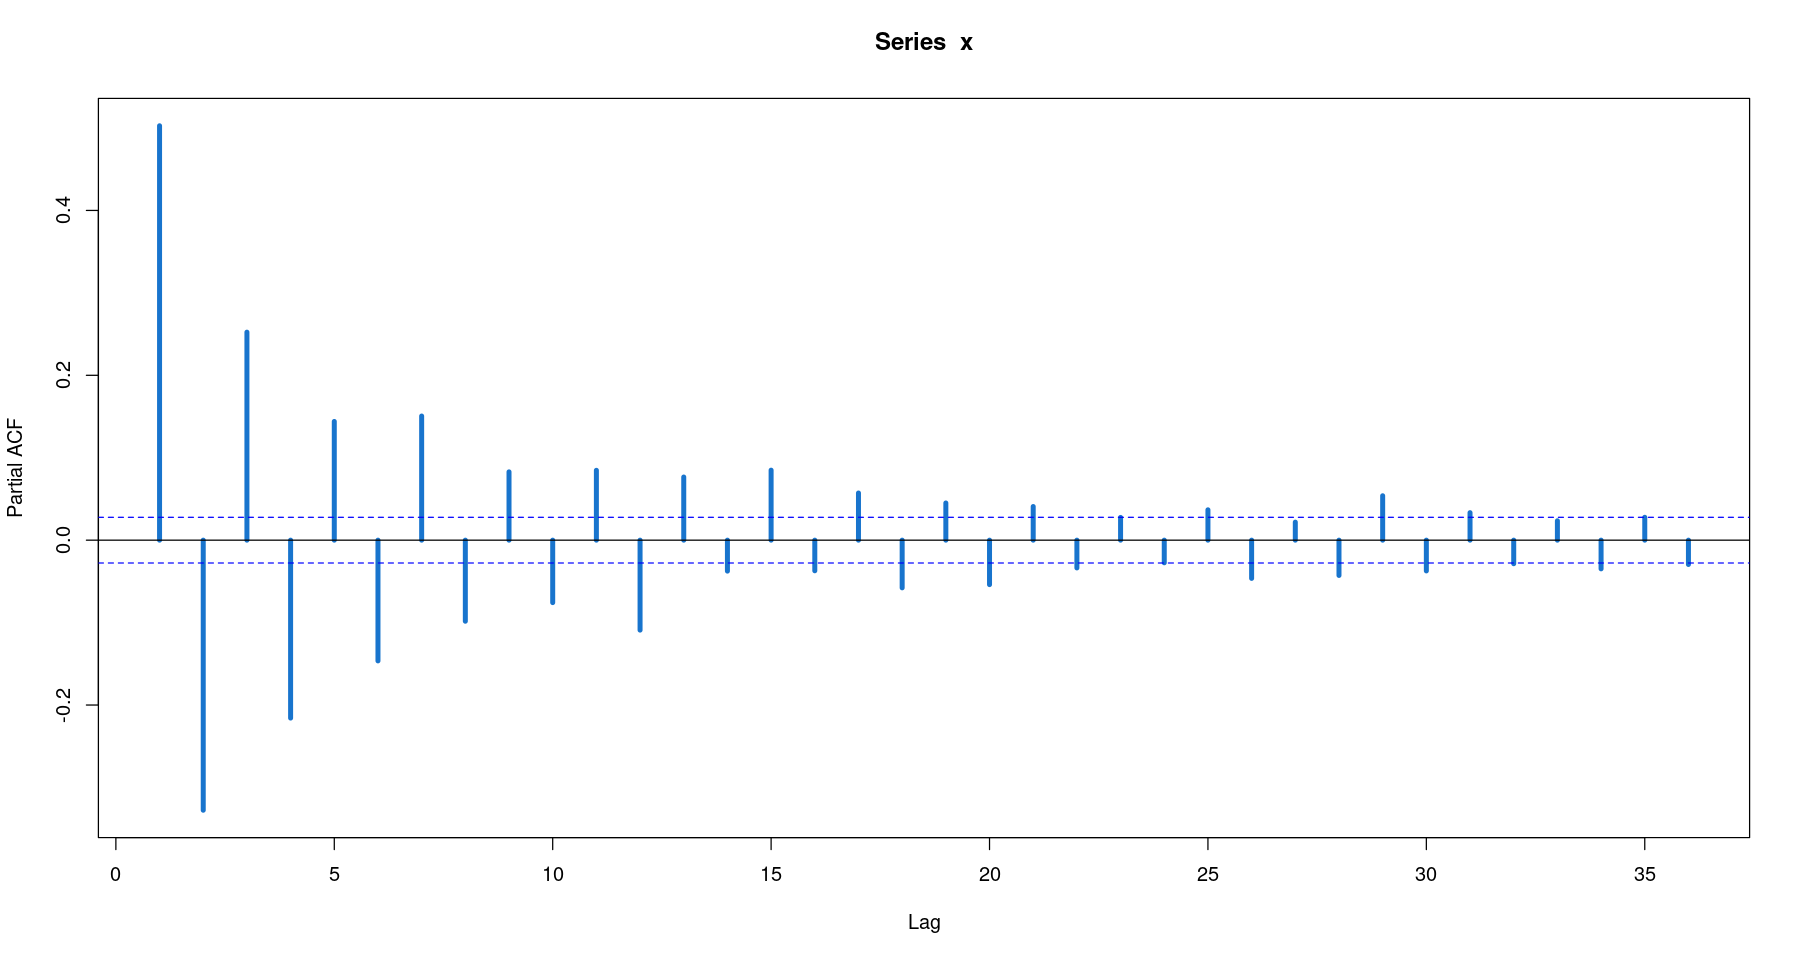

In [6]:
x=arima.sim(list(order=c(0,0,1), ma=c(1)), n=5000)

pacf(x, col=4, lwd=4)

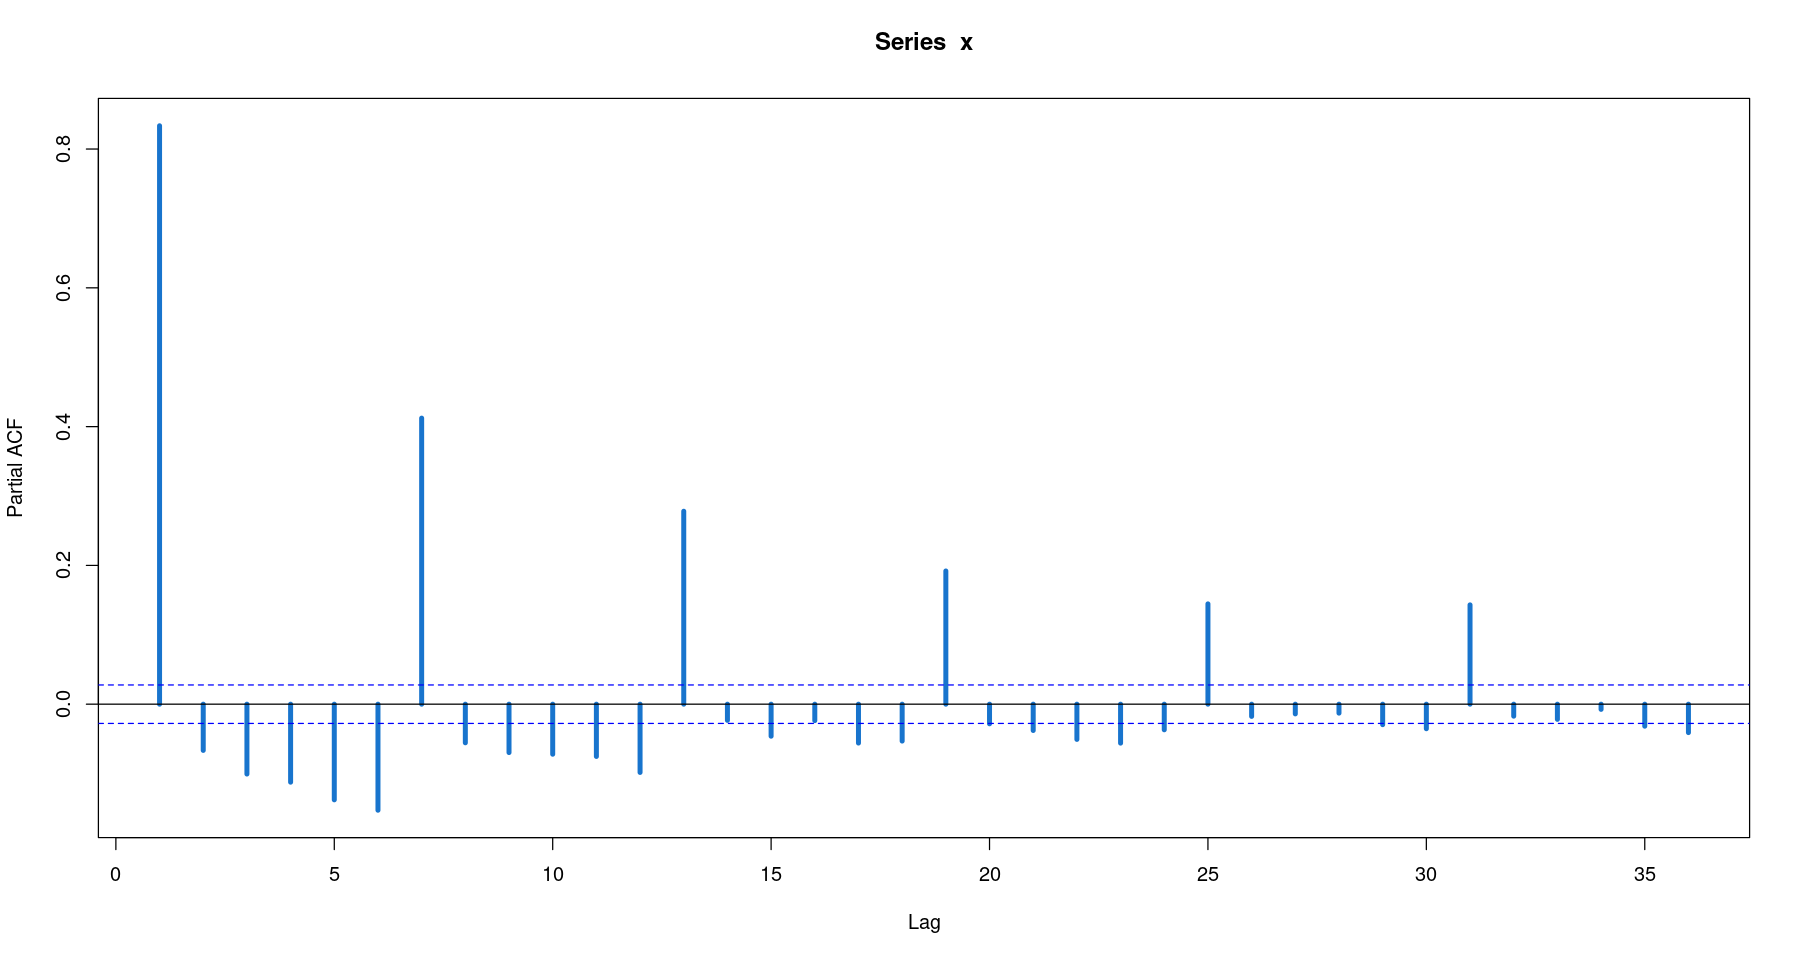

In [7]:
x=arima.sim(list(order=c(0,0,5), ma=rep(1,5)), n=5000)

pacf(x, col=4, lwd=4)

### Resumen:

En el proceso $MA(q)$ :

* La función de autocorrelación tiene $q$ lags activos.
* La función de autocorrelación parcial decae lentamente

Es decir, a la inversa de lo que ocurre en AR.

### Ajuste de un proceso $MA(q)$

Comencemos por el $MA(1)$ dado por:

$$x_t = w_t + \theta w_{t-1}.$$

El proceso $w_t$ no es directamente observable, entonces no podemos hacer una regresión a sus valores anteriores. Deberíamos "despejar" $w_t$ de algún modo.

Observemos la siguiente recursión:

$$ \left.\begin{array}{c}
    x_t = w_t + \theta w_{t-1} \\
    x_{t-1} = w_{t-1} + \theta w_{t-2}\end{array}\right\} \Rightarrow x_t = w_t + \theta x_{t-1} -\theta^2 w_{t-2}$$
    
Siguiendo la recursión, si $|\theta|<1$ el modelo se dice *invertible* y podemos escribir:

$$ x_{t} = \sum_{j=1}^\infty (-\theta)^j x_{t-j} +w_t$$

es decir, convertimos un $MA(1)$ en un $AR(\infty)$ en cierto modo. Como $\theta^j$ es decreciente, podríamos hacer una regresión y tratar de adivinar $\theta$.

**Problema**: Es no lineal en $\theta$ lo que estamos buscando.

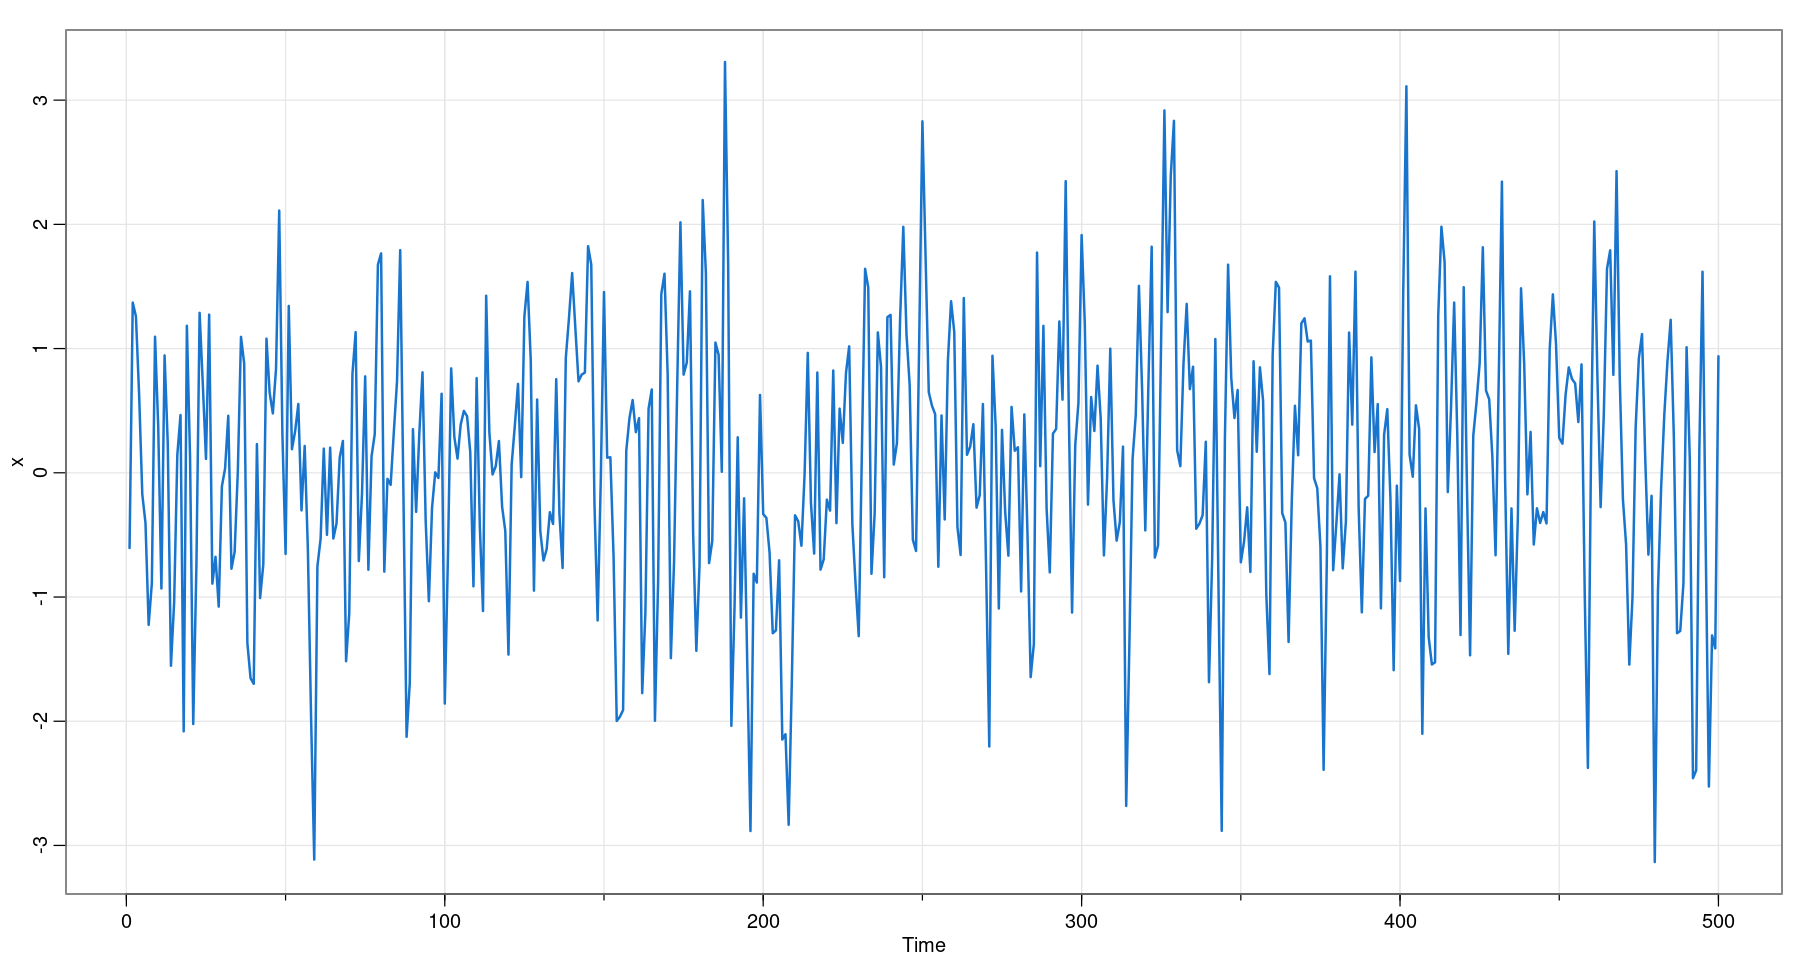

In [8]:
## Ejemplo: simulo un MA(1) con theta = 0.5 y hago varios fits

x=arima.sim(list(order=c(0,0,1), ma=0.5), n=500)
x=ts(x)
tsplot(x, col=4, lwd=2)


In [9]:
n_series = ts.intersect(x,xt1=lag(x,-1))

fit <- lm(x~0+xt1,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + xt1, data = n_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0677 -0.6083  0.0919  0.7212  3.3041 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.35423    0.04193   8.449 3.26e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.011 on 498 degrees of freedom
Multiple R-squared:  0.1254,	Adjusted R-squared:  0.1236 
F-statistic: 71.38 on 1 and 498 DF,  p-value: 3.255e-16


In [10]:
n_series = ts.intersect(x,xt1=lag(x,-1),xt2=lag(x,-2))

fit <- lm(x~0+xt1+xt2,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + xt1 + xt2, data = n_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1941 -0.6379  0.1186  0.7027  3.5066 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.43217    0.04385   9.857  < 2e-16 ***
xt2 -0.21385    0.04391  -4.871  1.5e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9872 on 496 degrees of freedom
Multiple R-squared:  0.1667,	Adjusted R-squared:  0.1634 
F-statistic: 49.62 on 2 and 496 DF,  p-value: < 2.2e-16


In [11]:
n_series = ts.intersect(x,xt1=lag(x,-1),xt2=lag(x,-2),xt3=lag(x,-3))

fit <- lm(x~0+xt1+xt2+xt3,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + xt1 + xt2 + xt3, data = n_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2430 -0.6462  0.0743  0.6985  3.4194 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.45897    0.04465  10.280  < 2e-16 ***
xt2 -0.27060    0.04769  -5.674 2.37e-08 ***
xt3  0.13438    0.04463   3.011  0.00274 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.98 on 494 degrees of freedom
Multiple R-squared:   0.18,	Adjusted R-squared:  0.175 
F-statistic: 36.14 on 3 and 494 DF,  p-value: < 2.2e-16


**Problema:** el procedimiento anterior no es muy práctico, y si quisiéramos hacer regresión no lineal necesitamos un buen estimador inicial de $\theta$. Además no generaliza bien a $q$.

**Método de los momentos:** es otra idea válida, recordemos la función de autocorrelación del $MA(1)$.


$$\rho(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

Si estimamos la correlación de orden uno de los datos (es decir la `acf(x)` en el lag $1$) podemos plantear:

$$\hat{\rho} (1) = \hat{\rho} = \frac{\theta}{1+\theta^2},$$

y despejar $\theta$:
$$\hat{\rho} \theta^2 - \theta + \hat{\rho} = 0.$$

Es decir:
$$\theta = \frac{1 \pm \sqrt{1-4\hat{\rho}^2}}{2 \hat{\rho}}.$$

**Observación**: dos soluciones!! ¿Cuál elijo? ¿Y además qué pasa si da complejo?

* Se elije la "invertible", es decir aquella que da menor a $1$.
* En teoría $\rho(1)<0.5$ si $\theta<1$ entonces no puede dar complejo. Pero al estimar $\rho$ por $\hat{\rho}$ puede ocurrir.
* Para estimar $\sigma^2_w$, la varianza del ruido, podemos usar que $\sigma^2_x = (1+\theta^2)\sigma^2_w$ y usar el valor de $\theta$ estimado.

[1] 0.4109423

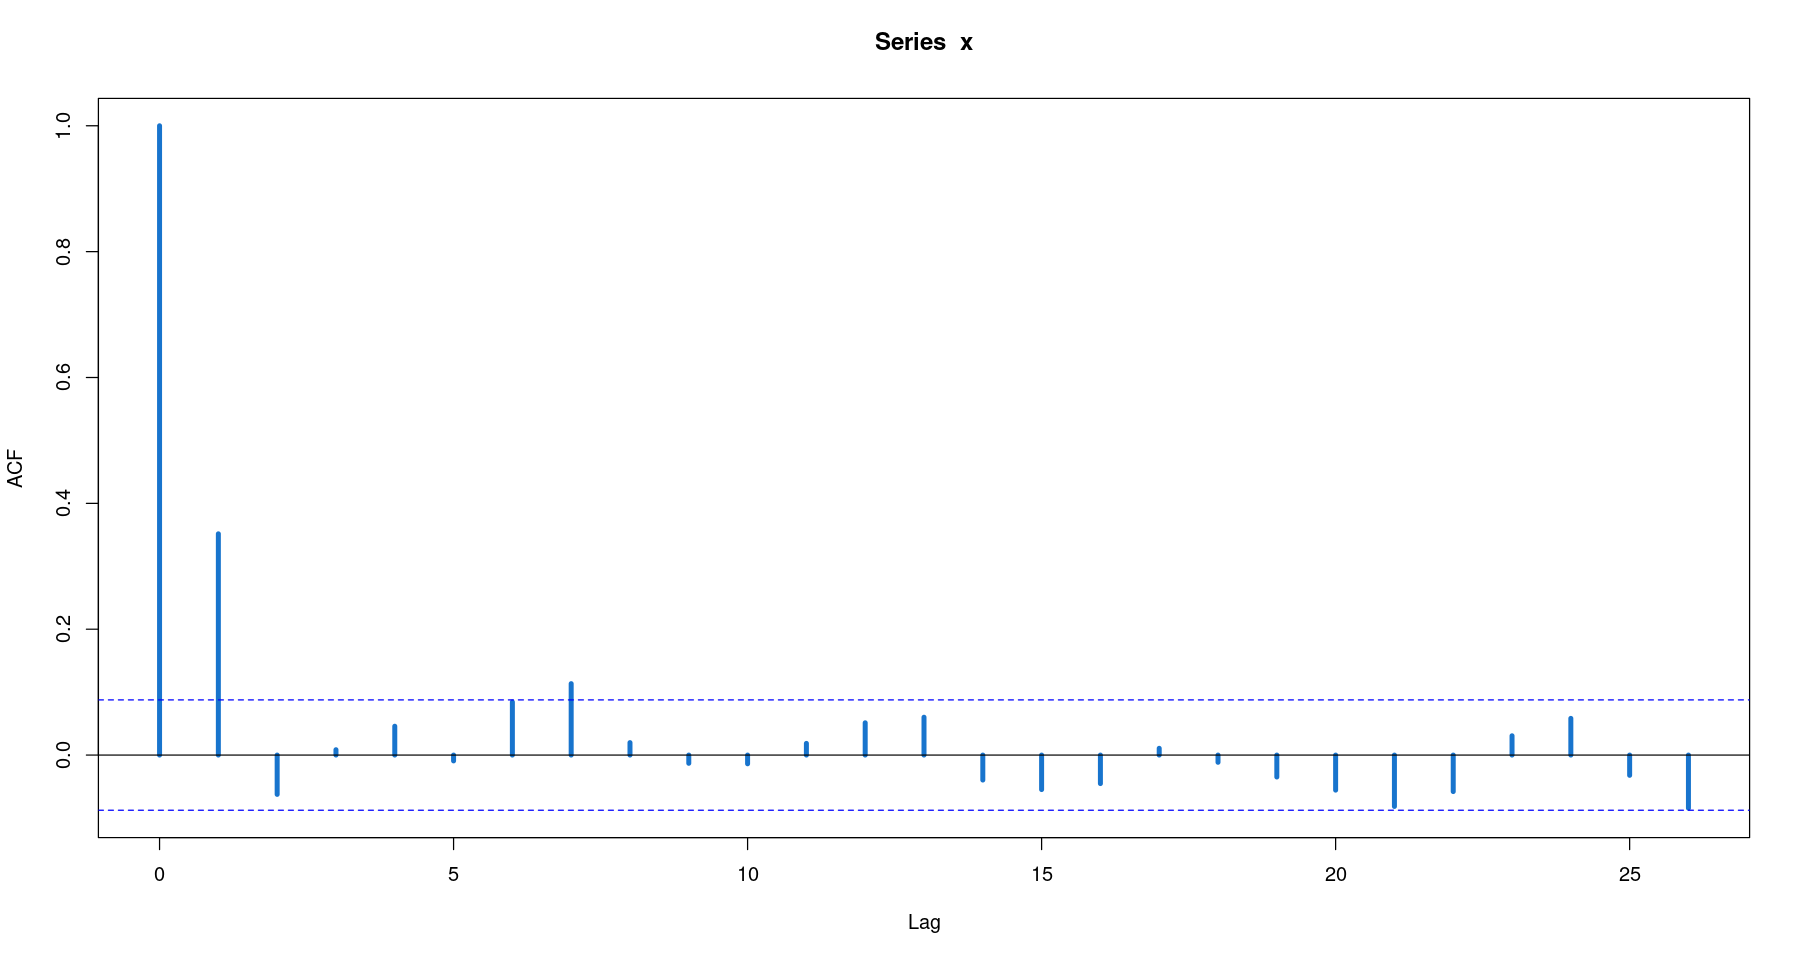

In [12]:
#### Ejemplo
acf(x, lwd=4, col=4)
rho=acf(x,1,plot=F)
r=rho$acf[2]

theta = (1-sqrt(1-4*r^2))/(2*r)
theta

In [13]:
# Estimo la varianza del ruido por método de los momentos despejando (debería dar 1 en este caso).
var(x)/(1+theta^2)

[1] 0.9951738

* El método de los momentos se puede generalizar a mayor orden, y también se puede utilizar en el caso $AR(p)$ (donde se denominan Ecuaciones de Yule-Walker). 

* Sin embargo, en la práctica, estos estimadores no son los más eficientes. En general, si los ruidos son gaussianos, conviene usar un enfoque de *máxima verosimilitud*. Este es el método que utiliza R.

* Discutiremos más este método en relación al modelo completo ARMA.


In [14]:
# Ejemplo

fit = arima(x,order = c(0,0,1), include.mean=F)
fit


Call:
arima(x = x, order = c(0, 0, 1), include.mean = F)

Coefficients:
         ma1
      0.4768
s.e.  0.0391

sigma^2 estimated as 0.9622:  log likelihood = -699.96,  aic = 1403.91

## Modelos ARMA

Un modelo $ARMA(p,q)$ es simplemente la combinación de los dos modelos vistos anteriormente. En términos matemáticos, $x_t$ es un modelo ARMA si se verifica:

$$x_t = \phi_1 x_{t-1} + \ldots + \phi_p x_{t-p} + w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q}$$

con $\phi_p$ y $\theta_q$ distintos de $0$. Los coeficientes $\phi_j$ son los coeficientes de la parte autorregresiva, y los $\theta_j$ los de la parte media móvil. Como siempre, $w_t$ es ruido blanco (gaussiano) de varianza $\sigma^2_w$.

### Ejemplo: ARMA(1,1)

Consideremos el siguiente proceso:

$$x_t = \phi x_{t-1} + w_t + \theta w_{t-1}$$

Con $\phi = 0.9$, $\theta = 0.5$.

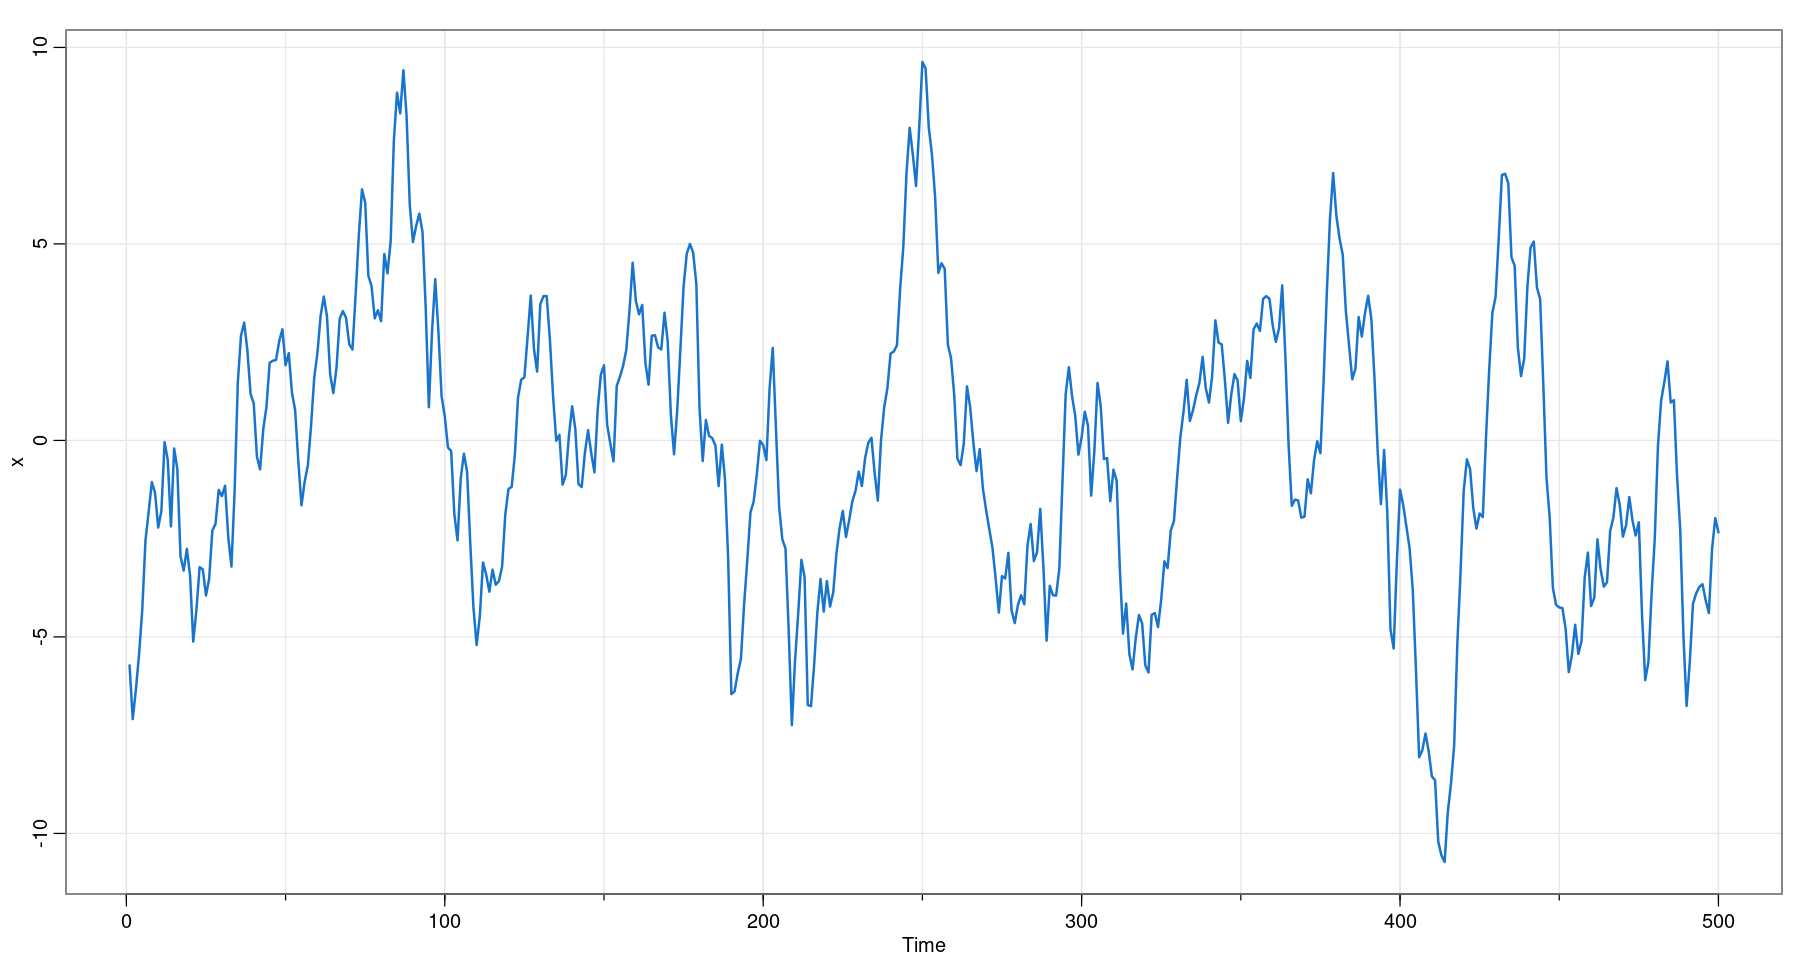

In [15]:
x <- arima.sim(list(order=c(1,0,1), ar=0.9, ma=0.5), n=500)
tsplot(x, ylab="x", col=4, lwd=2)  

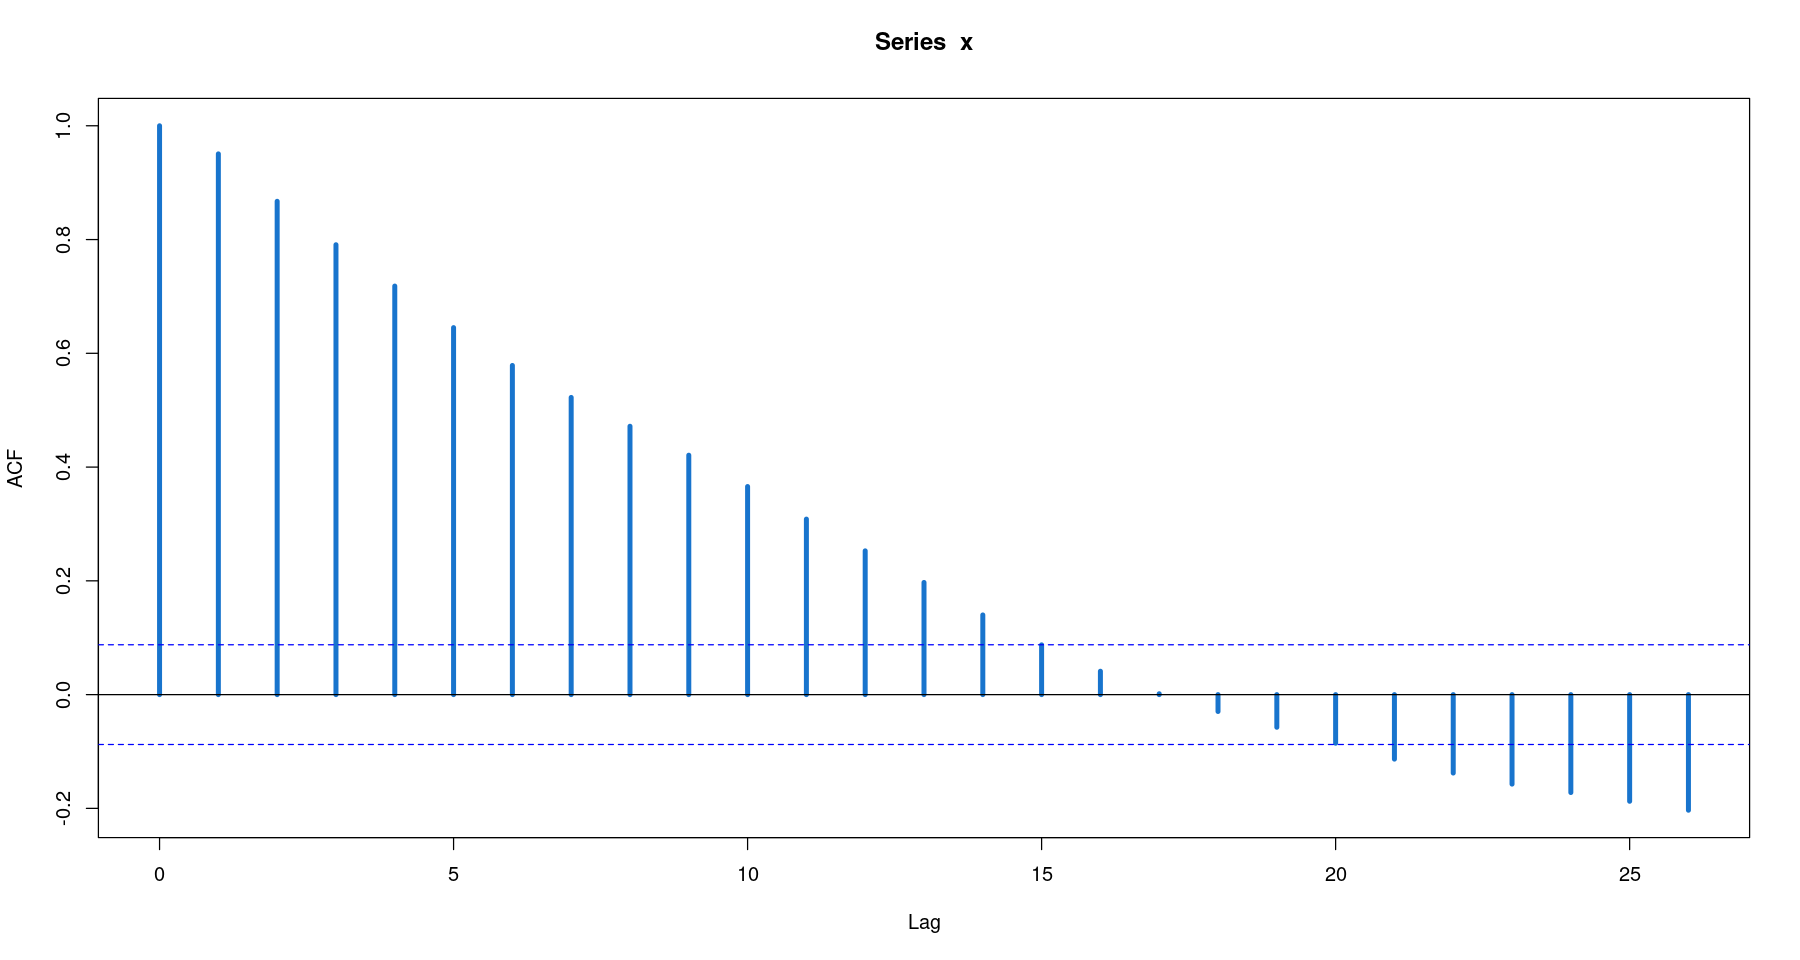

In [16]:
acf(x, col=4, lwd=4)

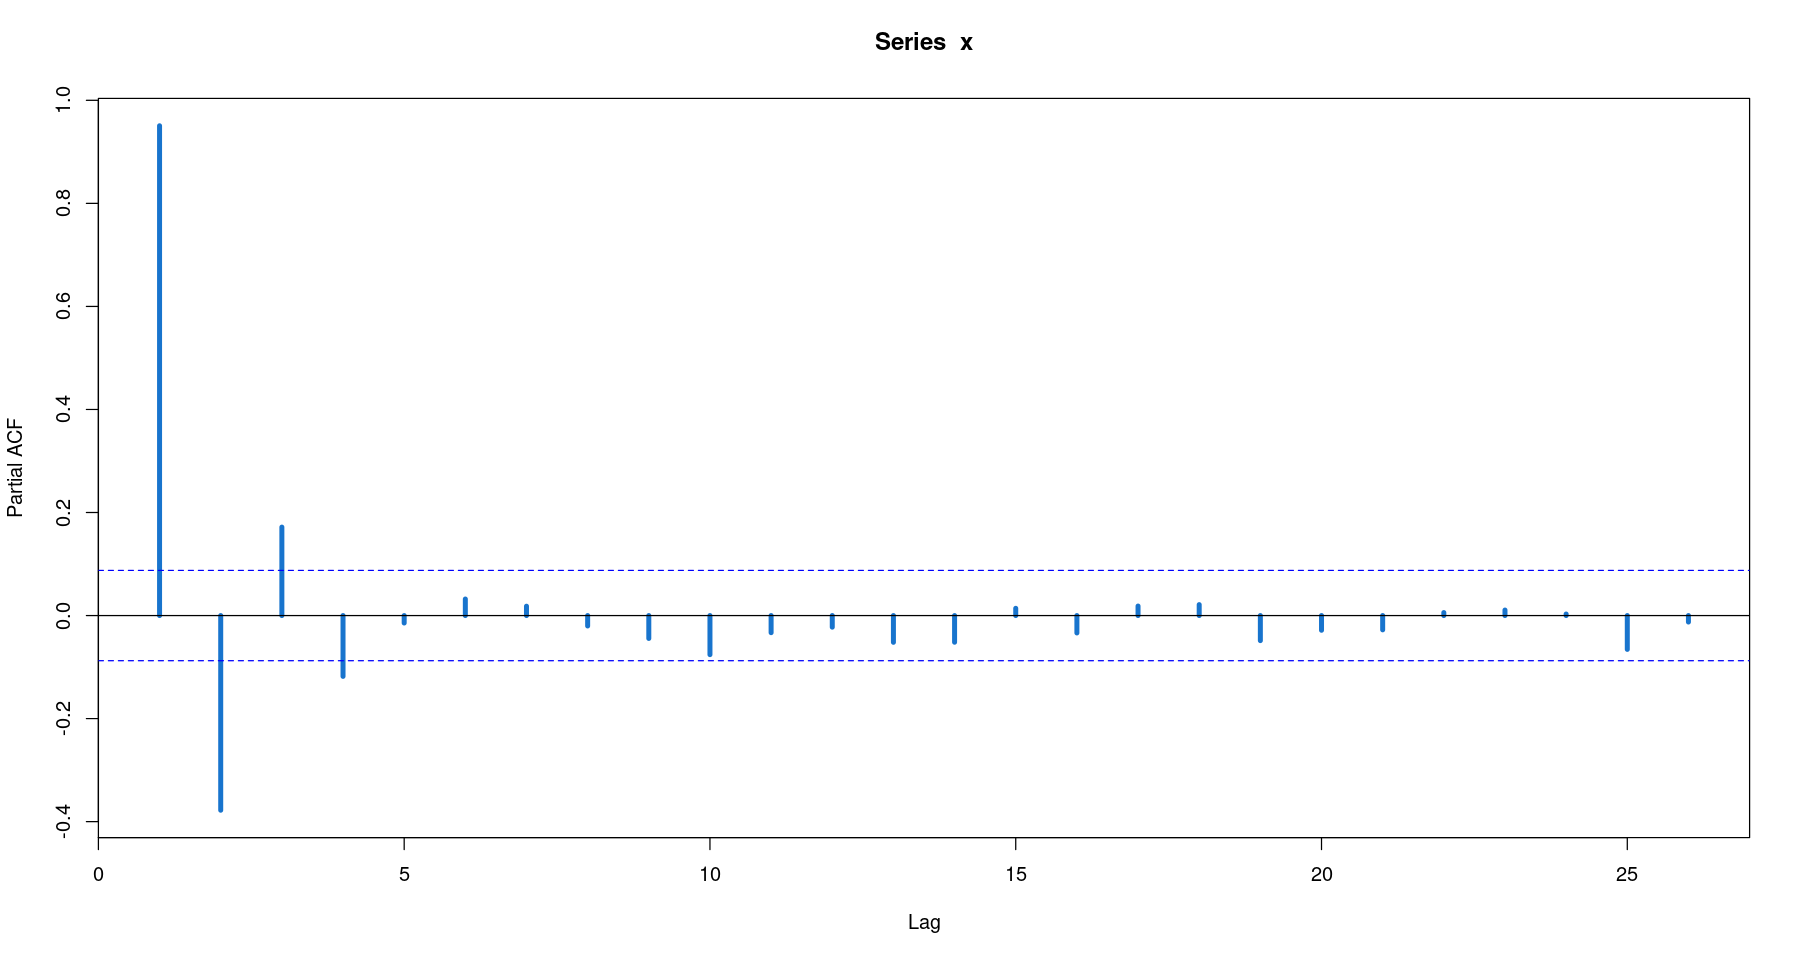

In [17]:
pacf(x, col=4, lwd=4)

**Problema:** Ahora la ACF y PACF no son tan claros estimadores del orden del modelo!!

En general, para un modelo ARMA(p,q) *tanto las ACF como la PACF decaen a 0 exponencialmente*.

Aquí no queda otra que "probar" el orden y cortar en base a algún criterio tipo el AIC o BIC.

### Ajuste de un modelo ARMA(1,1)

In [18]:
fit = arima(x,order = c(1,0,1), include.mean=F)
fit


Call:
arima(x = x, order = c(1, 0, 1), include.mean = F)

Coefficients:
         ar1     ma1
      0.9179  0.4869
s.e.  0.0181  0.0390

sigma^2 estimated as 0.9624:  log likelihood = -701.31,  aic = 1408.63

### Causalidad, invertibilidad.

**Observación**: No todos los juegos de parámetros $\phi_j$, $\theta_j$ son posibles. Algunos juegos de parámetros pueden producir procesos *no estacionarios*, o con parámetros no bien definidos.

**Ejemplo:** Consideremos un proceso $AR(1)$ con $|\phi_1| > 1$, se tiene que:

$$x_t = \phi_1 x_{t-1} + w_t.$$

Este proceso amplifica el valor de la muestra anterior. Eventualmente explota!

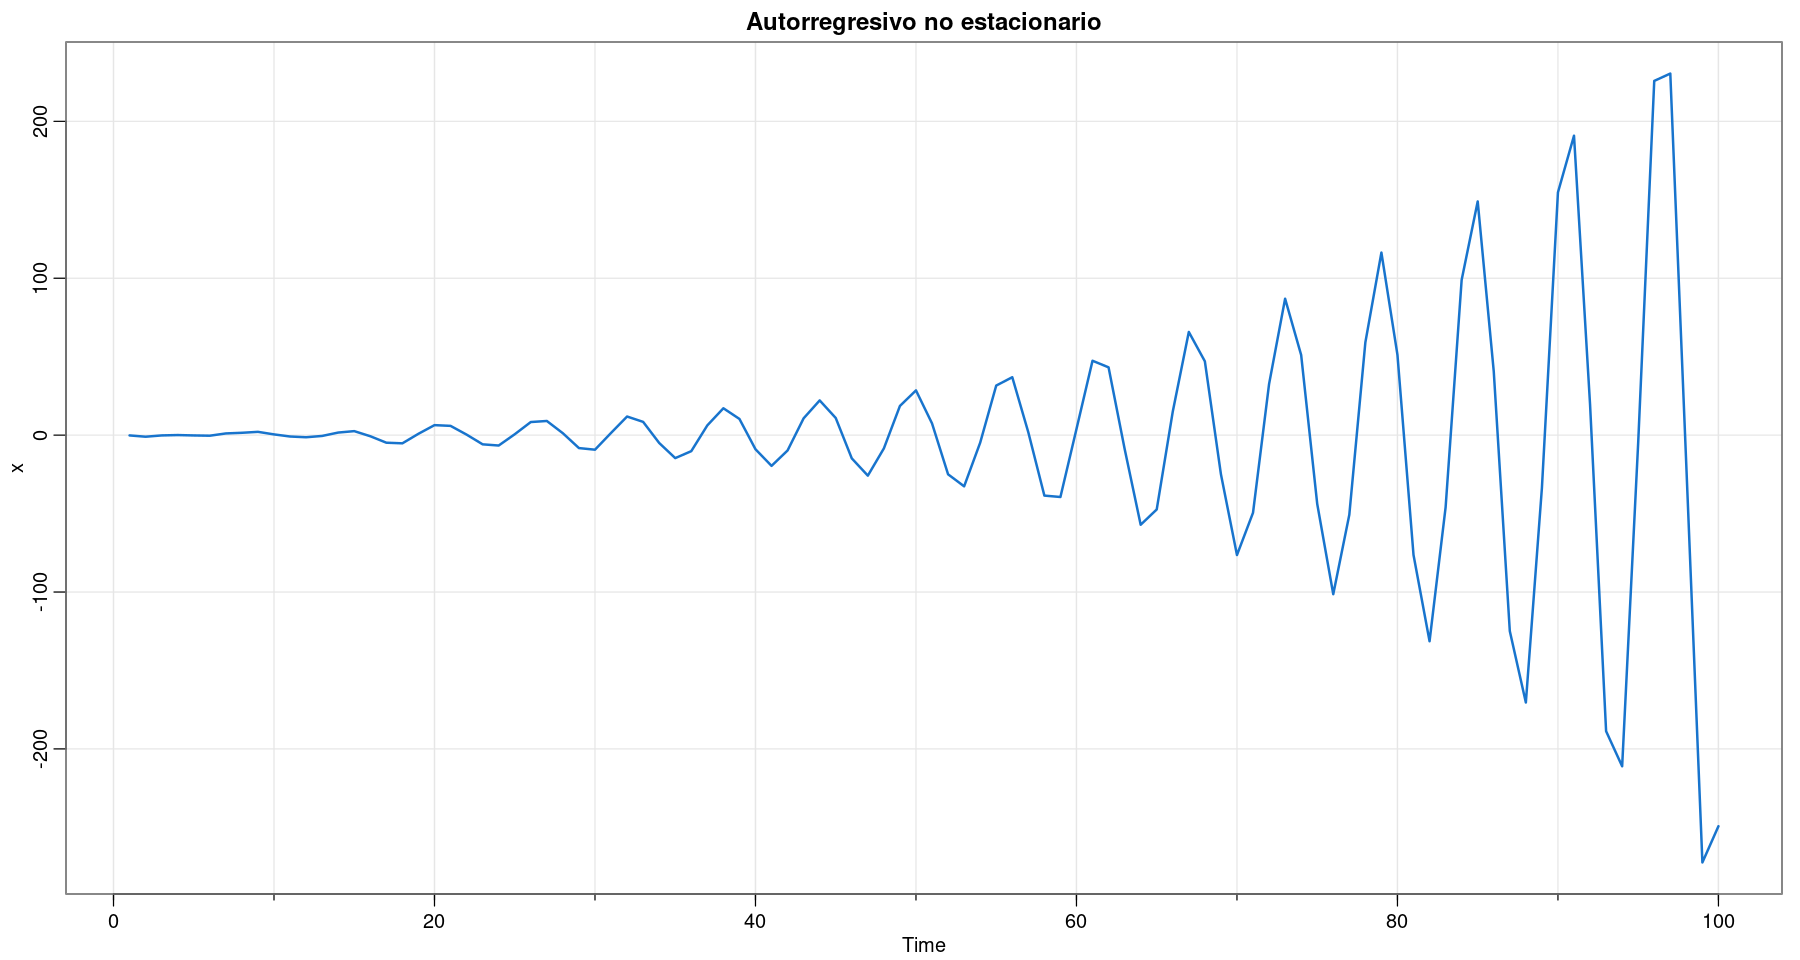

In [19]:
# AR con explosion

#Si le pido a R que lo simule no funciona.
#x <- arima.sim(list(order=c(1,0,0), ar=1.1), n=10)

# Lo simulo a mano con phi_1 = -1.1

w <- rnorm(100,0,1)  # 100 N(0,1) variates
x <- filter(w, filter=c(1,-1.1), method="recursive")
tsplot(x, main="Autorregresivo no estacionario", col=4, lwd=2)

#### Polinomios del AR y MA:

Se definen los siguiente polinomios, asociados a los coeficientes de la parte AR y MA:

$$\phi(z) = 1-\phi_1 z - \phi_2 z^2 -\ldots -\phi_p z^p,$$

$$\theta(z) = 1+\theta_1 z + \theta_2 z^2  + \ldots + \theta_q z^q.$$


#### Causalidad:

Un proceso ARMA es causal si se puede escribir solo como función de las innovaciones pasadas:

$$x_t = \sum_{j=0}^\infty \psi_j \phi_{t-j}.$$
con coeficientes $\psi$ a determinar y $\sum_{j=0}^\infty |\psi_j| <\infty$.

**Teorema:** Un proceso ARMA(p,q) es causal (no explosivo) si y solo si las raíces del polinomio $\phi(z)$ están todas fuera del círculo unitario (es decir, |z|>1 en toda raíz).

**Ejemplo:** Si $x_t$ es un AR(1), entonces $\phi(z) = 1-\phi_1 z$, y la raíz está fuera de $[-1,1]$ si y solo si $|\phi_1|<1$.


#### Invertibilidad:

Un proceso ARMA es invertible si se puede "despejar" $w_t$ de los valores pasados del proceso:

$$w_t = \sum_{j=0}^\infty \pi_j x_{t-j},$$
con coeficientes $\pi$ a determinar y $\sum_{j=0}^\infty |\pi_j| <\infty$.

**Teorema:** Un proceso ARMA(p,q) es invertible si y solo si las raíces del polinomio $\theta(z)$ están todas fuera del círculo unitario (es decir, |z|>1 en toda raíz).

### Ajuste de un modelo ARMA

El ajuste se realiza entonces mediante máxima verosimilitud o métodos de los momentos, buscando siempre un modelo *causal* e *invertible*.

Discutiremos los detalles en próximas cuadernos. Usaremos sin embargo la función `arima.fit` o sus variantes para ajustar modelos tipo ARMA.

## Ejercicio

Analizar la serie de grosor glacial del paquete `astsa` (serie `varve`). Aplicar la transformación `diff(log(x))` para obtener una serie estacionaria y discutir el ajuste de un modelo $MA(q)$ y $ARMA(p,q)$. 

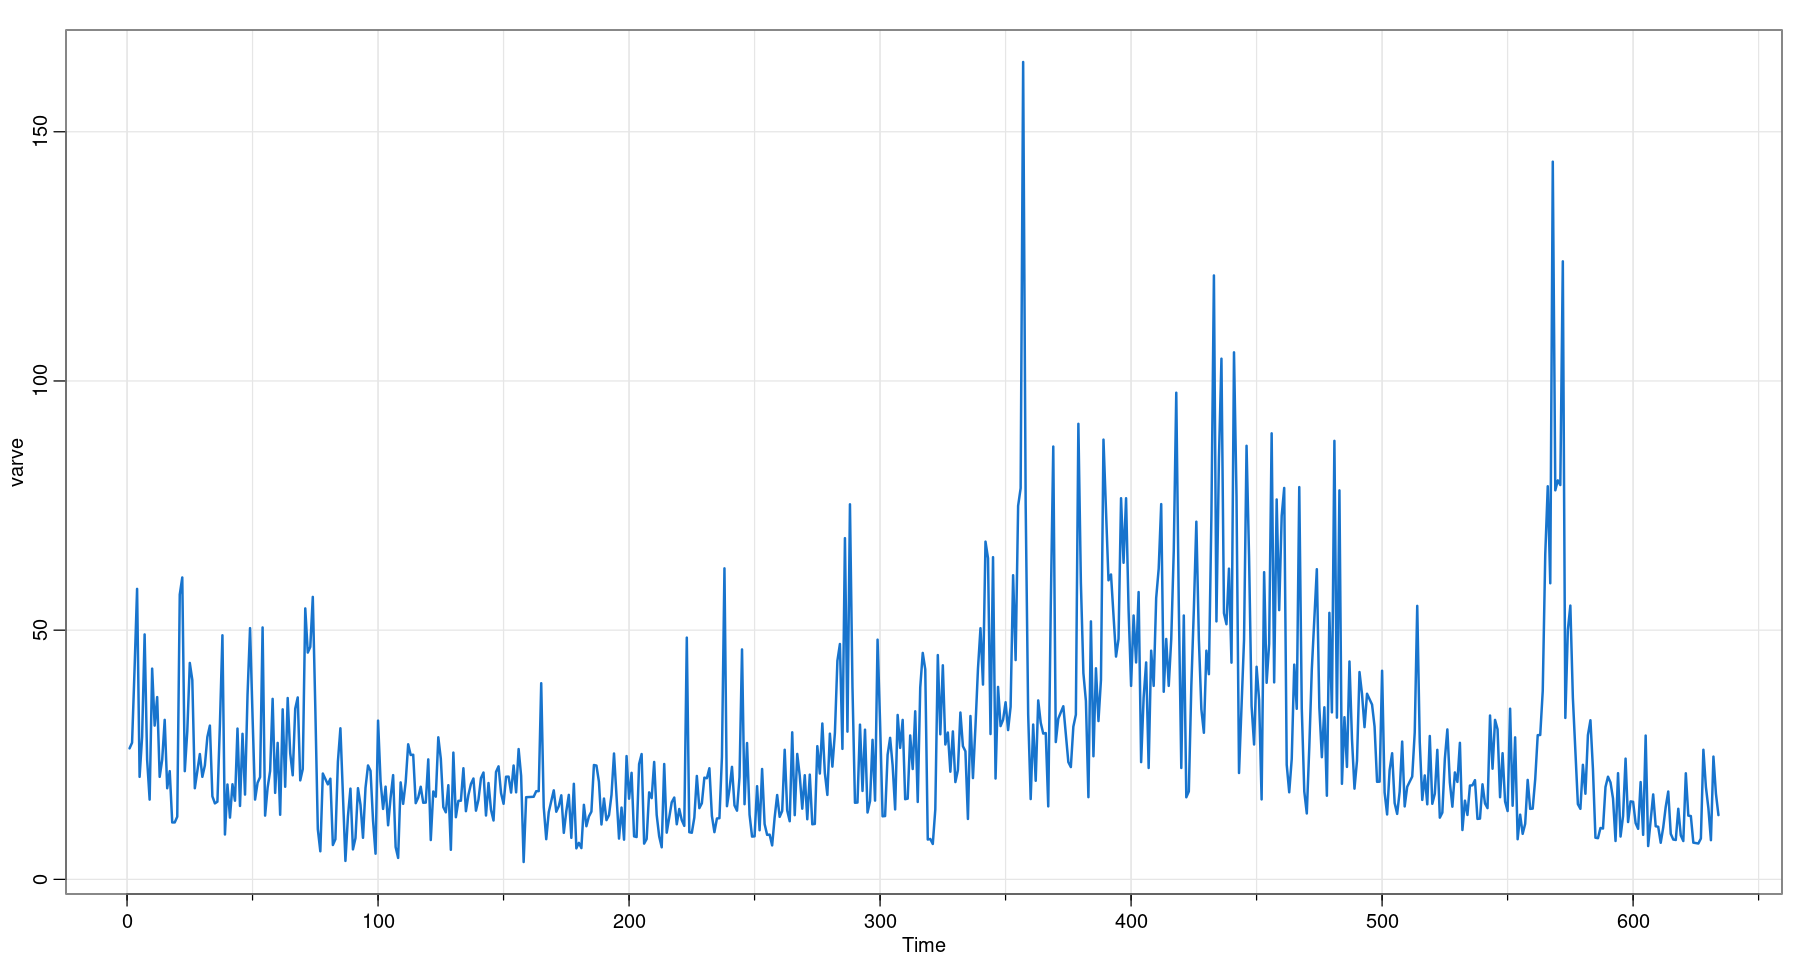

In [20]:
tsplot(varve, col=4, lwd=2)